In [1]:
import numpy as np
import pandas as pd

#### Imports

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

#### Loading Data

In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

# Exploratory Data Analysis

### Looking at the Feature names

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


`RecipeName`, `CommentID`, `UserID`, `UserName` and `Recipe_Review` are text based features. Rest are numeric features. \
`Recipe_Review` features has two records with null values.


### Removing Null Values

In [5]:
train_data.dropna(how='any', inplace=True)

### Having a glimpse at the data 

In [6]:
train_data.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


`ID`, `CommentID`, `UserID` do not seem to provide any useful information. `CreationTimestamp` can be converted into a more readable format.

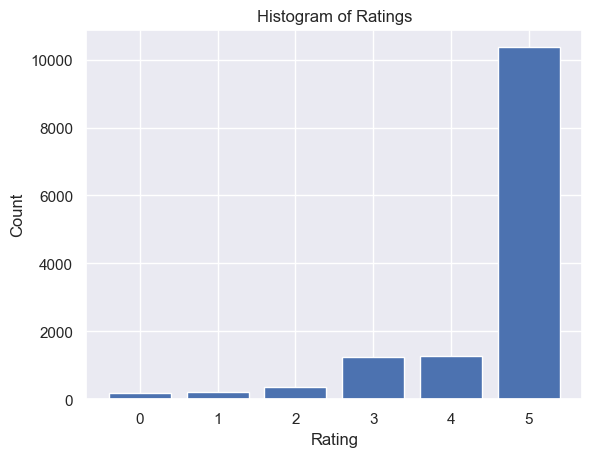

In [7]:
plt.bar([0, 1, 2, 3, 4, 5], 
        height=train_data['Rating'].value_counts(ascending=True))
plt.title("Histogram of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count");

We can see that the dataset is highly imbalanced with more than 70% concentrated in a single class.

### Adding Time Features

In [8]:
def add_features(X):
    X['Date']=pd.to_datetime(X['CreationTimestamp'], unit='s')
    X['Day']=X['Date'].dt.day_name()
    X['Hour']=X['Date'].apply(lambda x: x.hour + x.minute/60)
    return X

train_data=add_features(train_data)
test_data=add_features(test_data)

`add_features()` method adds `Date`, `Day` and `Hour` features to the train and test datasets.

### Looking at Time features

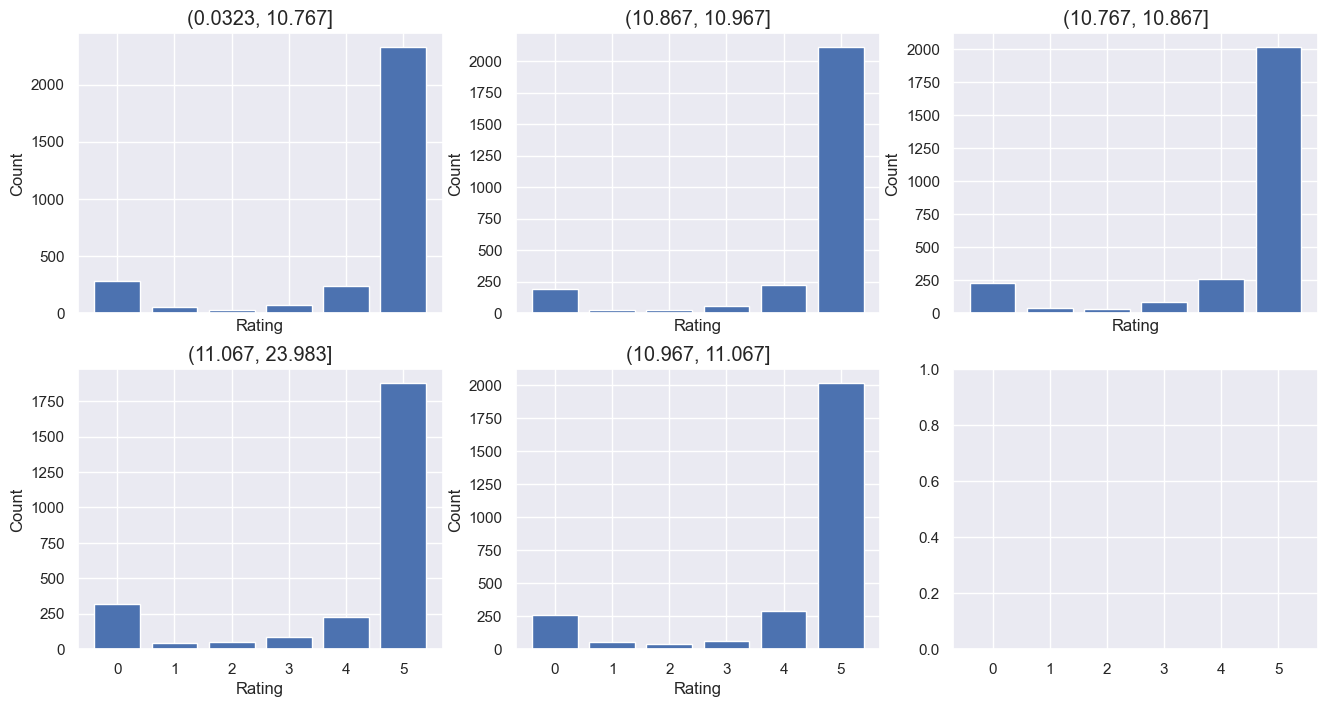

In [9]:
def plot_hour(data):
    new_data=data.copy()
    new_data['Hour_Category']=pd.qcut(new_data['Hour'], 5)
    fig, axs=plt.subplots(2, 3, sharex=True)
    fig.set_size_inches(16, 8)
    for i, hour in enumerate(new_data['Hour_Category'].unique()):
        data=new_data.loc[new_data['Hour_Category']==hour]
        plot_data=data['Rating'].value_counts(ascending=True)
        axs[int(i/3), i%3].bar(plot_data.index, plot_data.values)
        axs[int(i/3), i%3].set_title(hour, fontsize='large')
        axs[int(i/3), i%3].set_ylabel('Count')
        axs[int(i/3), i%3].set_xlabel('Rating')
plot_hour(train_data)

`plot_hour()` method divides the `Hour` feature of the dataset into 5 quantiles and plots a bar chart of counts of ratings for each quantile. \
We can see that no matter what time of the day it is, users have posted reviews with rating 5 the most.

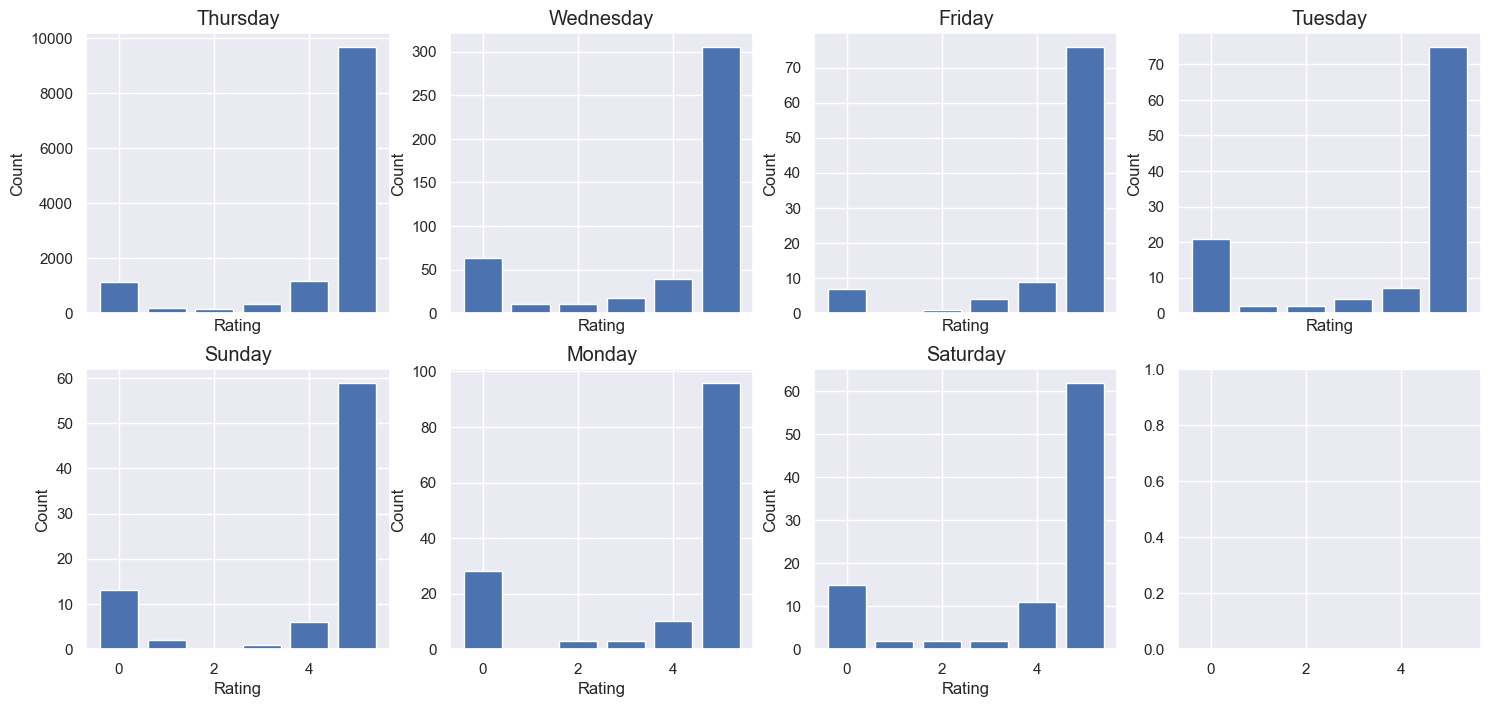

In [10]:
def plot_day(dataset):
    fig, axs=plt.subplots(2, 4, sharex=True)
    fig.set_size_inches(18, 8)
    for i, day in enumerate(dataset['Day'].unique()):
        data=dataset.loc[dataset['Day']==day]
        plot_data=data['Rating'].value_counts(ascending=True)
        axs[int(i/4), i%4].bar(plot_data.index, plot_data.values)
        axs[int(i/4), i%4].set_title(day, fontsize="large")
        axs[int(i/4), i%4].set_xlabel("Rating")
        axs[int(i/4), i%4].set_ylabel("Count")
plot_day(train_data)

`plot_day()` method plots the bar chart of counts of different ratings for each day of the week. \
We can see that the distribution of ratings is pretty much identical for all days. \
It is also observed that almost all reviews were made on a `Thursday` (close to 10000). This feature does not seem to be useful.

### Looking at Numerical Features

In [11]:
train_data[['RecipeNumber', 'UserReputation', 'ReplyCount',
            'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']].describe()

,RecipeNumber,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore
count,13634.000000,13634.000000,13634.000000,13634.000000,13634.000000,13634.00000
mean,38.629382,2.160481,0.014523,1.098430,0.543788,153.13569
std,29.671643,10.087154,0.137333,4.166771,3.265893,140.99578
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,12.000000,1.000000,0.000000,0.000000,0.000000,100.00000
50%,33.000000,1.000000,0.000000,0.000000,0.000000,100.00000
75%,63.000000,1.000000,0.000000,0.000000,0.000000,100.00000
max,100.000000,510.000000,3.000000,80.000000,126.000000,946.00000


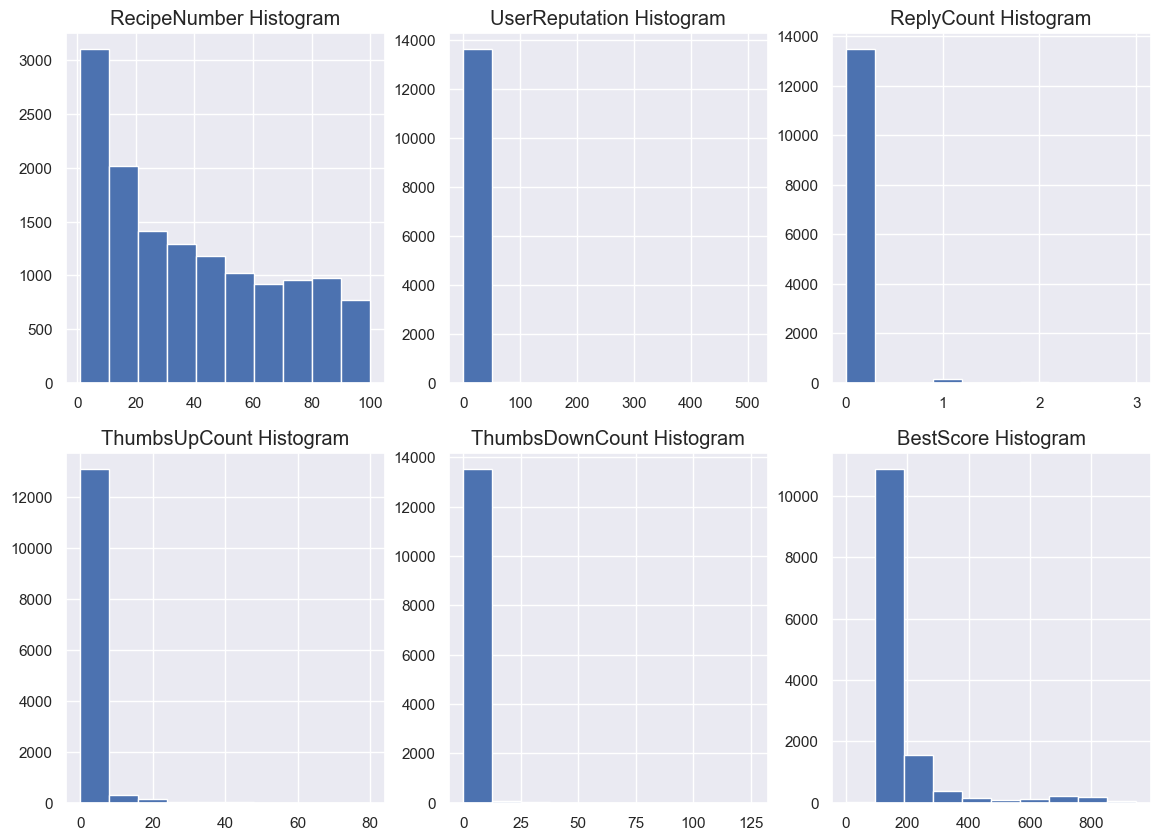

In [12]:
def plot_numerical(dataset):
    fig, axs=plt.subplots(2, 3)
    fig.set_size_inches(14, 10)
    for i, feature in enumerate(['RecipeNumber', 'UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']):
        axs[int(i/3), i%3].hist(dataset[feature])
        axs[int(i/3), i%3].set_title(feature+" Histogram", fontsize="large")
plot_numerical(train_data)

From the above two cells, it is evident that most features except `RecipeNumber` have very little variance. \
`ReplyCount` and `ThumbsDownCount` have a value of 0 for almost all records.

# Logistic Regression

### Dividing Dataset into training and validation sets

`X` contains the whole training dataset without the `Rating` feature. \
`y` contains the `Rating` feature corresponding to `X`. \
`X_train` contains the subset of data on which all models will be trained. \
`y_train` contains the `Rating` feature corresponding to `X_train`. \
`X_valid` contains the subset of data on which all models will be validated. \
`y_valid` contains the `Rating` feature corresponding to `X_valid`. 


In [13]:
X, y=train_data.drop('Rating', axis=1), train_data['Rating']
X_test=test_data
X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.2, random_state=29)

In [14]:
compare=pd.Series(index=pd.MultiIndex.from_product([['Logistic Regression', 'SVM',
                                                     'Bagging', 'RandomForrest'],
                                                    ['TrainScore', 'ValidationScore']]), dtype=float)

### Pipeline

In [15]:
col_transform=ColumnTransformer([('scaler', StandardScaler(), ['RecipeNumber', 'UserReputation',
                                                             'ReplyCount', 'ThumbsUpCount',
                                                             'ThumbsDownCount', 'BestScore']),
                                 ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
                                                                  strategy='quantile', random_state=29, subsample=None),
                                                                  ['Hour']),
                                 ('vectorizer', CountVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])

pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', LogisticRegression(penalty='l2', solver='lbfgs', n_jobs=-1,
                                               multi_class='multinomial'))])

In this pipeline : 
* Step-1 is a ColumnTransformer which Standardizes the numerical features, encodes the hour feature with one-hot encoding and processes text review with CountVecorizer
* Step-2 is a FunctionTransformer that changes the sparse matrix returned by previous step into a dense matrix.
* Step-3 is LogisticRegression classifier

In [16]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  CountVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x00000211C64F4790>)),
                ('clsf',
                 LogisticRegression(multi_class='multinomial', n_jobs=-1))])

#### Train Report

In [17]:
train_predict=pipeline.predict(X_train)
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.83      0.43      0.57      1002
           1       0.96      0.80      0.87       167
           2       0.97      0.67      0.79       136
           3       0.95      0.70      0.81       291
           4       0.85      0.46      0.60      1014
           5       0.87      0.99      0.93      8297

    accuracy                           0.87     10907
   macro avg       0.91      0.67      0.76     10907
weighted avg       0.87      0.87      0.86     10907



#### Validation Report

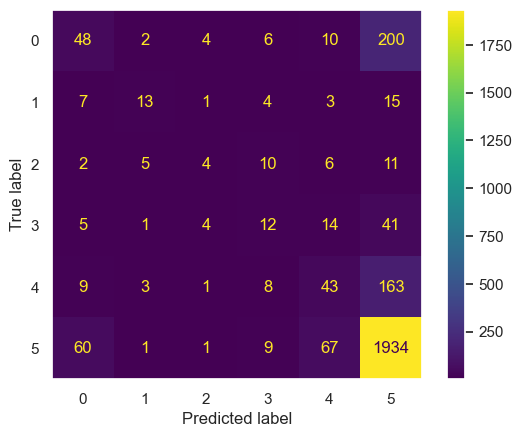

In [18]:
valid_predict=pipeline.predict(X_valid)
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);
plt.grid(False)

In [19]:
print(classification_report(y_valid, valid_predict, zero_division=0), accuracy_score(y_valid, valid_predict))

              precision    recall  f1-score   support

           0       0.37      0.18      0.24       270
           1       0.52      0.30      0.38        43
           2       0.27      0.11      0.15        38
           3       0.24      0.16      0.19        77
           4       0.30      0.19      0.23       227
           5       0.82      0.93      0.87      2072

    accuracy                           0.75      2727
   macro avg       0.42      0.31      0.34      2727
weighted avg       0.70      0.75      0.72      2727
 0.7532086541987532


We can see that due to high imbalance in data, the model is not able to predict classes correctly. \
To tackle this let us train the model with cross validation.
#### Cross Validation using Grid Search

In [20]:
gscv=GridSearchCV(estimator=pipeline, param_grid={'clsf__C': [0.015, 0.2, 0.5, 1]}, cv=4, n_jobs=-1)
gscv.fit(X_train, y_train)
gscv.best_params_, gscv.best_score_

({'clsf__C': 0.2}, 0.7659299709623689)

Let us re-define the pipeline with better hyperparameters

In [21]:
pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', LogisticRegression(penalty='l2', solver='lbfgs', n_jobs=-1,
                                               multi_class='multinomial', C=0.2))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  CountVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x00000211CA8436D0>)),
                ('clsf',
                 LogisticRegression(C=0.2, multi_class='multinomial',
                                    n_jobs=-1))])

#### Validation Report 

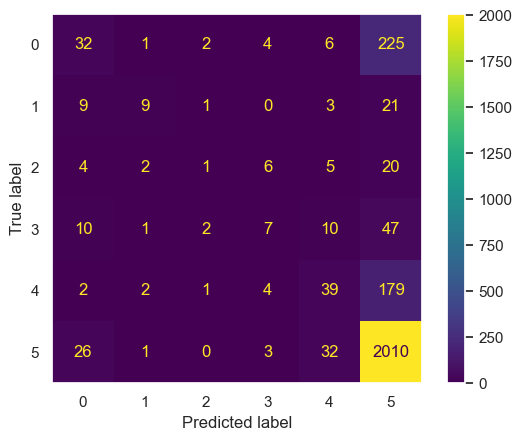

In [22]:
compare['Logistic Regression', 'TrainScore']=pipeline.score(X_train, y_train)
compare['Logistic Regression', 'ValidationScore']=pipeline.score(X_valid, y_valid)
valid_predict=pipeline.predict(X_valid)
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);
plt.grid(False)

In [23]:
print(classification_report(y_valid, valid_predict, zero_division=0), accuracy_score(y_valid, valid_predict))

              precision    recall  f1-score   support

           0       0.39      0.12      0.18       270
           1       0.56      0.21      0.31        43
           2       0.14      0.03      0.04        38
           3       0.29      0.09      0.14        77
           4       0.41      0.17      0.24       227
           5       0.80      0.97      0.88      2072

    accuracy                           0.77      2727
   macro avg       0.43      0.26      0.30      2727
weighted avg       0.70      0.77      0.72      2727
 0.7693436010267694


The performance of the model has improved but the it still produces poor recall in many classes. 

# SVM

### Pipeline

In [24]:
col_transform=ColumnTransformer([('scaler', StandardScaler(), ['RecipeNumber', 'UserReputation',
                                                             'ReplyCount', 'ThumbsUpCount',
                                                             'ThumbsDownCount', 'BestScore']),
                                 ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
                                                                  strategy='quantile', random_state=29, subsample=None),
                                                                  ['Hour']),
                                 ('vectorizer', TfidfVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])

weights={0: 4, 1: 8, 2: 12, 3: 6, 4: 3.5, 5: 1.8}
pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', LinearSVC(random_state=29, multi_class='ovr', max_iter=1000))])

This pipeline is very similar to the Logistic Regression Pipeline. The only difference being in the last step, LinearSVC model is used. 

In [25]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  TfidfVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x00000211C9F78790>)),
                ('clsf', LinearSVC(random_state=29))])

#### Train Report

In [26]:
train_predict=pipeline.predict(X_train)
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.82      0.35      0.49      1002
           1       0.98      0.77      0.86       167
           2       0.96      0.58      0.72       136
           3       0.90      0.49      0.64       291
           4       0.78      0.30      0.44      1014
           5       0.85      0.99      0.91      8297

    accuracy                           0.85     10907
   macro avg       0.88      0.58      0.68     10907
weighted avg       0.84      0.85      0.82     10907



#### Validation Report

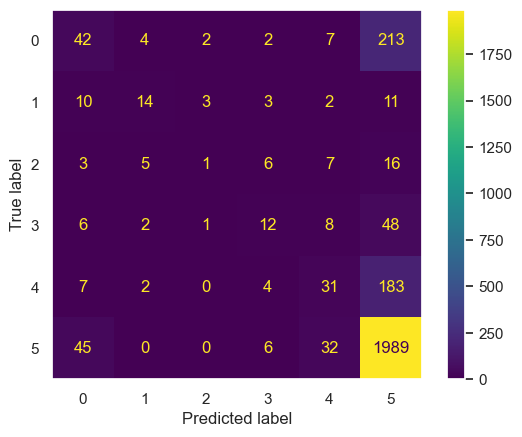

In [27]:
valid_predict=pipeline.predict(X_valid)
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);
plt.grid(False)

In [28]:
print(classification_report(y_valid, valid_predict, zero_division=0), accuracy_score(y_valid, valid_predict))

              precision    recall  f1-score   support

           0       0.37      0.16      0.22       270
           1       0.52      0.33      0.40        43
           2       0.14      0.03      0.04        38
           3       0.36      0.16      0.22        77
           4       0.36      0.14      0.20       227
           5       0.81      0.96      0.88      2072

    accuracy                           0.77      2727
   macro avg       0.43      0.29      0.33      2727
weighted avg       0.70      0.77      0.72      2727
 0.766043270993766


We can see that due to high imbalance in data, the model is not able to predict classes correctly. \
It is also observed that this model is performing better than Logistic Regression. 
#### Cross Validation using Grid Search

In [29]:
gscv=GridSearchCV(estimator=pipeline, param_grid={'clsf__C': [0.5, 1],
                                                  'clsf__loss': ['hinge', 'squared_hinge'],
                                                  'clsf__class_weight' : [weights, None]}, cv=4, n_jobs=-1)
gscv.fit(X_train, y_train)
gscv.best_params_, gscv.best_score_

({'clsf__C': 1, 'clsf__class_weight': None, 'clsf__loss': 'hinge'},
 0.7709727471891235)

Let us re-define the pipeline with better hyperparameters

In [30]:
pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', LinearSVC(random_state=29, multi_class='ovr', max_iter=1000,
                                      loss='hinge'))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  TfidfVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x00000211C6859360>)),
                ('clsf', LinearSVC(loss='hinge', random_state=29))])

#### Validation Report 

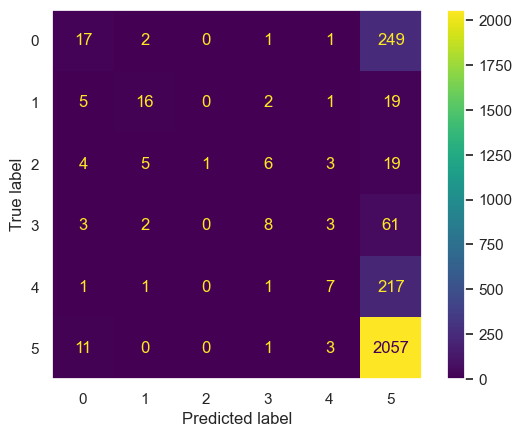

In [31]:
compare['SVM', 'TrainScore']=pipeline.score(X_train, y_train)
compare['SVM', 'ValidationScore']=pipeline.score(X_valid, y_valid)
valid_predict=pipeline.predict(X_valid)
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);
plt.grid(False)

In [32]:
print(classification_report(y_valid, valid_predict, zero_division=0), accuracy_score(y_valid, valid_predict))

              precision    recall  f1-score   support

           0       0.41      0.06      0.11       270
           1       0.62      0.37      0.46        43
           2       1.00      0.03      0.05        38
           3       0.42      0.10      0.17        77
           4       0.39      0.03      0.06       227
           5       0.78      0.99      0.88      2072

    accuracy                           0.77      2727
   macro avg       0.60      0.26      0.29      2727
weighted avg       0.71      0.77      0.69      2727
 0.7722772277227723


# Bagging Classifier

### Pipeline

In [33]:
col_transform=ColumnTransformer([('scaler', StandardScaler(), ['RecipeNumber', 'UserReputation',
                                                             'ReplyCount', 'ThumbsUpCount',
                                                             'ThumbsDownCount', 'BestScore']),
                                 ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
                                                                  strategy='quantile', random_state=29, subsample=None),
                                                                  ['Hour']),
                                 ('vectorizer', TfidfVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])

weights={0: 4, 1: 8, 2: 12, 3: 6, 4: 3.5, 5: 1.8}
base=DecisionTreeClassifier(splitter='random', random_state=29, class_weight=weights)
pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', BaggingClassifier(n_jobs=-1, random_state=29, estimator=base,
                                              max_samples=0.75, max_features=0.7, oob_score=True, 
                                              n_estimators=100))])

Since bagging takes more time, the model presented here is already tuned

In [34]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  TfidfVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x00000211C9F780D0>)),
                ('clsf',
                 BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={0: 4,
                                                                                  1: 8,
                                                                                  2: 12,
                                                                                  3: 6,
                                                                                  4: 3.5,
                                                                                  5: 1.8},
                                                                    random_state=29,
                                                                    splitter='random'),
                                   max_features=0.7, max_samples=0.75,
                                   n_estimators=100, n_jobs=-1, oob_score=True,
                                   random_state=29))])

#### Train Report

In [35]:
train_predict=pipeline.predict(X_train)
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1002
           1       1.00      0.99      1.00       167
           2       1.00      0.99      0.99       136
           3       1.00      0.98      0.99       291
           4       1.00      0.97      0.99      1014
           5       0.99      1.00      1.00      8297

    accuracy                           0.99     10907
   macro avg       1.00      0.98      0.99     10907
weighted avg       0.99      0.99      0.99     10907



#### Validation Report

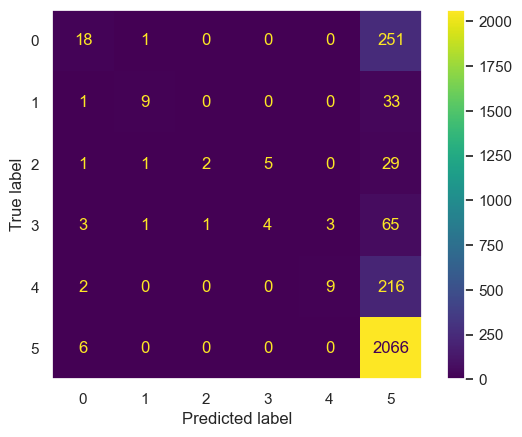

In [36]:
compare['Bagging', 'TrainScore']=pipeline.score(X_train, y_train)
compare['Bagging', 'ValidationScore']=pipeline.score(X_valid, y_valid)
valid_predict=pipeline.predict(X_valid)
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);
plt.grid(False)

In [37]:
print(classification_report(y_valid, valid_predict, zero_division=0), accuracy_score(y_valid, valid_predict))

              precision    recall  f1-score   support

           0       0.58      0.07      0.12       270
           1       0.75      0.21      0.33        43
           2       0.67      0.05      0.10        38
           3       0.44      0.05      0.09        77
           4       0.75      0.04      0.08       227
           5       0.78      1.00      0.87      2072

    accuracy                           0.77      2727
   macro avg       0.66      0.24      0.26      2727
weighted avg       0.74      0.77      0.69      2727
 0.773010634396773


We can definitely observe that this model is producing more accurate results than the previous two models. \
This may be because Bagging trains various models and averages their results. This reduces the possibility of overfitting and generally lead to better performance.

# RandomForrest

### Pipeline

In [38]:
col_transform=ColumnTransformer([('scaler', StandardScaler(), ['RecipeNumber', 'UserReputation',
                                                             'ReplyCount', 'ThumbsUpCount',
                                                             'ThumbsDownCount', 'BestScore']),
                                 ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
                                                                  strategy='quantile', random_state=29, subsample=None),
                                                                  ['Hour']),
                                 ('vectorizer', TfidfVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])

pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', RandomForestClassifier(n_jobs=-1, random_state=29,
                                                   oob_score=True, max_samples=1.0, max_features=47,
                                                   n_estimators=310))])

Since RandomForrest takes more time, the model presented here is already tuned

In [39]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  TfidfVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x00000211C9E1D900>)),
                ('clsf',
                 RandomForestClassifier(max_features=47, max_samples=1.0,
                                        n_estimators=310, n_jobs=-1,
                                        oob_score=True, random_state=29))])

#### Train Report

In [40]:
train_predict=pipeline.predict(X_train)
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1002
           1       1.00      1.00      1.00       167
           2       1.00      1.00      1.00       136
           3       1.00      1.00      1.00       291
           4       1.00      1.00      1.00      1014
           5       1.00      1.00      1.00      8297

    accuracy                           1.00     10907
   macro avg       1.00      1.00      1.00     10907
weighted avg       1.00      1.00      1.00     10907



#### Validation Report

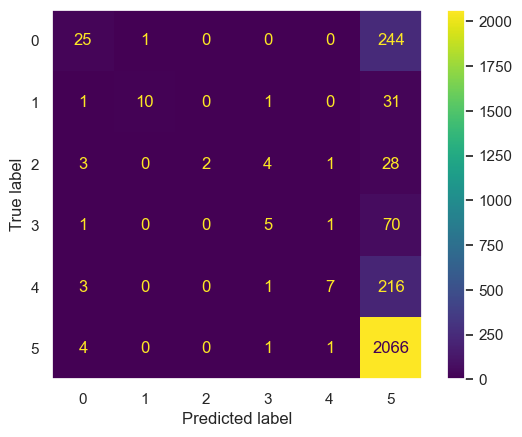

In [41]:
compare['RandomForrest', 'TrainScore']=pipeline.score(X_train, y_train)
compare['RandomForrest', 'ValidationScore']=pipeline.score(X_valid, y_valid)
valid_predict=pipeline.predict(X_valid)
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);
plt.grid(False)

In [42]:
print(classification_report(y_valid, valid_predict, zero_division=0), accuracy_score(y_valid, valid_predict))

              precision    recall  f1-score   support

           0       0.68      0.09      0.16       270
           1       0.91      0.23      0.37        43
           2       1.00      0.05      0.10        38
           3       0.42      0.06      0.11        77
           4       0.70      0.03      0.06       227
           5       0.78      1.00      0.87      2072

    accuracy                           0.78      2727
   macro avg       0.75      0.25      0.28      2727
weighted avg       0.76      0.78      0.70      2727
 0.7755775577557755


# Comparing Models

<AxesSubplot: >

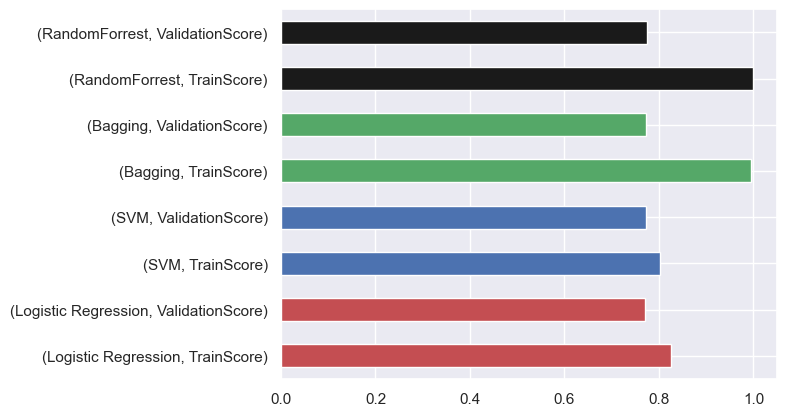

In [43]:
compare.plot.barh(color=['r', 'r', 'b', 'b', 'g', 'g',
                         'k', 'k', 'y', 'y'])

In [44]:
compare.sort_values()

Logistic Regression  ValidationScore    0.769344
SVM                  ValidationScore    0.772277
Bagging              ValidationScore    0.773011
RandomForrest        ValidationScore    0.775578
SVM                  TrainScore         0.801870
Logistic Regression  TrainScore         0.825892
Bagging              TrainScore         0.994041
RandomForrest        TrainScore         0.999633
dtype: float64

We can see that RandomForrest produces the best results with the maximum TrainScore and ValidationScore. So we use RandomForrest for further prediction.

# Submission

In [45]:
pipeline.fit(X, y)
test_predict=pipeline.predict(X_test)
result_df=pd.DataFrame({'ID': range(1, len(test_predict)+1),
                       'Rating': test_predict})
result_df.head()

,ID,Rating
0,1,5
1,2,5
2,3,5
3,4,5
4,5,5


In [46]:
# result_df.to_csv('submission.csv', index=False)